In [1]:
%cd /content
!rm -rf /content/OptIForest
!git clone --depth 1 https://github.com/xiagll/OptIForest.git /content/OptIForest
%cd /content/OptIForest


/content
Cloning into '/content/OptIForest'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 0), reused 9 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (20/20), 191.65 KiB | 1.06 MiB/s, done.
/content/OptIForest


In [2]:
# np.mat to np.asmatrix (NumPy 2.0 compatibility)
!sed -i 's/np.mat(/np.asmatrix(/g' /content/OptIForest/detectors/opt_tree.py

In [3]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score

IN_COLAB = "google.colab" in sys.modules

# Base directory for processed data
if IN_COLAB:
    BASE_DIR = "/content/optiforest_data"
else:
    BASE_DIR = "./optiforest_data"
os.makedirs(BASE_DIR, exist_ok=True)

RANDOM_STATE = 42
ANOMALY_RATIO = 0.06        # 6% anomalies overall
FRACTION_OOR = 0.5          # half out-of-range, half perturbed
INCLUDE_TARGET_AS_FEATURE = False

np.random.seed(RANDOM_STATE)

In [4]:
def generate_out_of_range_anomalies(X: pd.DataFrame, n_rows: int, widen=0.2, min_out_cols=3):
    """
    Create anomalies by sampling in an extended range and ensuring
    at least 'min_out_cols' features per row fall outside the original min/max.
    """
    rng = np.random.default_rng(RANDOM_STATE)
    cols = X.columns
    Xmin = X.min().to_numpy()
    Xmax = X.max().to_numpy()
    Xrange = Xmax - Xmin
    low_ext = Xmin - widen * Xrange
    high_ext = Xmax + widen * Xrange

    A = rng.uniform(low_ext, high_ext, size=(n_rows, X.shape[1]))

    # Ensure at least some dimensions are out-of-range
    for i in range(n_rows):
        out_mask_low  = A[i] < Xmin
        out_mask_high = A[i] > Xmax
        out_mask = out_mask_low | out_mask_high
        k = out_mask.sum()
        if k < min_out_cols:
            # Force a few random columns outside range
            idxs = rng.choice(X.shape[1], size=min_out_cols, replace=False)
            # Push half low, half high
            half = min_out_cols // 2
            for j, c in enumerate(idxs):
                if j < half:
                    A[i, c] = low_ext[c] - rng.uniform(0.01, 0.1) * (Xrange[c] + 1e-6)
                else:
                    A[i, c] = high_ext[c] + rng.uniform(0.01, 0.1) * (Xrange[c] + 1e-6)
    return pd.DataFrame(A, columns=cols)

def generate_perturbed_anomalies(X: pd.DataFrame, n_rows: int, std_scale=3.0, swap_prob=0.2):
    """
    Create anomalies by perturbing copies of real rows:
    - add Gaussian noise scaled by column std
    - randomly swap a fraction of column pairs
    """
    rng = np.random.default_rng(RANDOM_STATE)
    cols = X.columns
    choice_idx = rng.integers(0, X.shape[0], size=n_rows)
    base = X.iloc[choice_idx].to_numpy().copy()

    col_std = X.std(ddof=0).replace(0, 1e-6).to_numpy()

    # Add noise
    noise = rng.normal(loc=0.0, scale=std_scale * col_std, size=base.shape)
    A = base + noise

    # Random column swaps (simulate subtle ETL/data-entry issues)
    for i in range(n_rows):
        if rng.uniform() < swap_prob:
            c1, c2 = rng.choice(X.shape[1], size=2, replace=False)
            A[i, [c1, c2]] = A[i, [c2, c1]]

    return pd.DataFrame(A, columns=cols)

In [5]:
#Fetch housing data
cal = fetch_california_housing(as_frame=True)
X_base = cal.data.copy()
y_target = cal.target

if INCLUDE_TARGET_AS_FEATURE:
    X_base = X_base.assign(MedHouseVal=y_target)

# Treat all original rows as 'normal'
n_base, d = X_base.shape
print(f"Base normal rows: {n_base}, features: {d}")
X_base.head()


Base normal rows: 20640, features: 8


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
# Deciding how many anomalies to inject
n_total = n_base
n_anom = int(math.ceil(ANOMALY_RATIO * n_total))
n_oor  = int(round(FRACTION_OOR * n_anom))
n_pert = n_anom - n_oor

print(f"Target anomalies: {n_anom}  (out-of-range: {n_oor}, perturbed: {n_pert})")

# Generating anomalies
X_oor  = generate_out_of_range_anomalies(X_base, n_rows=n_oor, widen=0.25, min_out_cols=3)
X_pert = generate_perturbed_anomalies(X_base, n_rows=n_pert, std_scale=3.0, swap_prob=0.25)

# Combining normals + anomalies
X_all = pd.concat([X_base, X_oor, X_pert], axis=0, ignore_index=True)
y_all = np.concatenate([np.zeros(n_base, dtype=int), np.ones(n_anom, dtype=int)])

print("Final dataset shape:", X_all.shape, "| Anomaly ratio:", y_all.mean())
X_all.head()


Target anomalies: 1239  (out-of-range: 620, perturbed: 619)
Final dataset shape: (21879, 8) | Anomaly ratio: 0.05662964486493898


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.25, random_state=RANDOM_STATE, stratify=y_all
)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Save processed CSVs
train_df = pd.DataFrame(X_train_s, columns=X_all.columns)
train_df["label_binary"] = y_train
test_df  = pd.DataFrame(X_test_s, columns=X_all.columns)
test_df["label_binary"] = y_test

train_csv = os.path.join(BASE_DIR, "cahousing_hybrid_train.csv")
test_csv  = os.path.join(BASE_DIR, "cahousing_hybrid_test.csv")
train_df.to_csv(train_csv, index=False)
test_df.to_csv(test_csv, index=False)

print("Saved:")
print("-", train_csv)
print("-", test_csv)


Saved:
- /content/optiforest_data/cahousing_hybrid_train.csv
- /content/optiforest_data/cahousing_hybrid_test.csv


In [8]:
# Baseline: IsolationForest
iso = IsolationForest(
    n_estimators=300,
    contamination="auto",
    random_state=RANDOM_STATE
)
iso.fit(X_train_s)
scores_test = -iso.decision_function(X_test_s)

auc = roc_auc_score(y_test, scores_test)
ap  = average_precision_score(y_test, scores_test)
print(f"[CAHousing] Baseline IsolationForest → AUC-ROC: {auc:.3f} | AUC-PR: {ap:.3f}")


[CAHousing] Baseline IsolationForest → AUC-ROC: 0.999 | AUC-PR: 0.990


In [9]:
# OptIForest on California Housing
from detectors.opt_iforest import OptIForest

THRESHOLD = 403   # same as your AD replication
BRANCH    = 0

optif = OptIForest(
    lsh_family="L2OPT",
    num_trees=100,
    threshold=THRESHOLD,
    branch=BRANCH,
    granularity=1,
)

print("\nFitting OptIForest on CAHousing hybrid dataset...")
optif.fit(X_train_s)

# Get anomaly scores (flip sign so higher = more anomalous)
if hasattr(optif, "decision_function"):
    scores_of = -np.asarray(optif.decision_function(X_test_s), dtype=float)
elif hasattr(optif, "score_samples"):
    scores_of = -np.asarray(optif.score_samples(X_test_s), dtype=float)
else:
    preds = optif.predict(X_test_s)
    scores_of = (np.asarray(preds) == -1).astype(float)

of_auc = roc_auc_score(y_test, scores_of)
of_ap  = average_precision_score(y_test, scores_of)

print(f"[CAHousing] OptIForest → AUC-ROC: {of_auc:.3f} | AUC-PR: {of_ap:.3f}")



Fitting OptIForest on CAHousing hybrid dataset...


/content/OptIForest/detectors/opt_tree.py:56: RuntimeWarning: invalid value encountered in scalar divide
  children[key] = self._recursive_build(child_data, depth_limit, min(0.0, (children_count[key] -mean) /std), cur_index +1)


[CAHousing] OptIForest → AUC-ROC: 0.993 | AUC-PR: 0.942


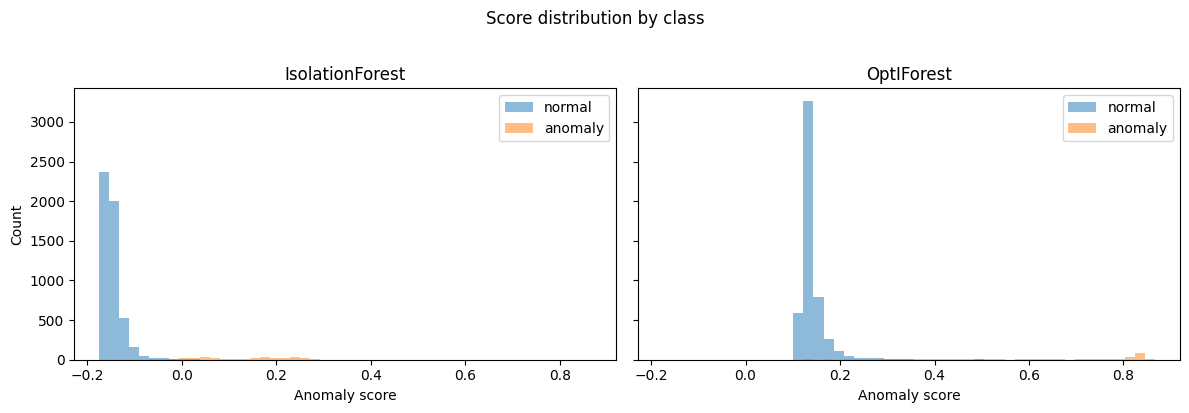

In [11]:
scores_iso = scores_test          # from IsolationForest

mask_normal = (y_test == 0)
mask_anom   = (y_test == 1)

vmin = float(min(scores_iso.min(), scores_of.min()))
vmax = float(max(scores_iso.max(), scores_of.max()))
bins = np.linspace(vmin, vmax, 50)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

axes[0].hist(scores_iso[mask_normal], bins=bins, alpha=0.5, label="normal")
axes[0].hist(scores_iso[mask_anom],   bins=bins, alpha=0.5, label="anomaly")
axes[0].set_title("IsolationForest")
axes[0].set_xlabel("Anomaly score")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(scores_of[mask_normal], bins=bins, alpha=0.5, label="normal")
axes[1].hist(scores_of[mask_anom],   bins=bins, alpha=0.5, label="anomaly")
axes[1].set_title("OptIForest")
axes[1].set_xlabel("Anomaly score")
axes[1].legend()

fig.suptitle("Score distribution by class", y=1.02)
plt.tight_layout()
plt.show()

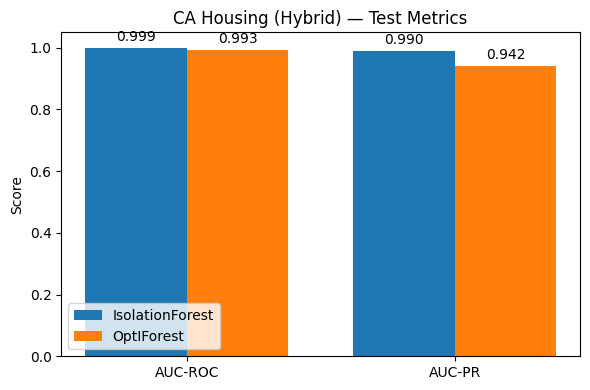

In [12]:
iso_auc = roc_auc_score(y_test, scores_test)
iso_ap  = average_precision_score(y_test, scores_test)
of_auc  = roc_auc_score(y_test, scores_of)
of_ap   = average_precision_score(y_test, scores_of)

metrics = ["AUC-ROC", "AUC-PR"]
iso_vals = [iso_auc, iso_ap]
of_vals  = [of_auc,  of_ap]

x = np.arange(len(metrics)); w = 0.38
fig, ax = plt.subplots(figsize=(6,4))
b1 = ax.bar(x - w/2, iso_vals, w, label="IsolationForest")
b2 = ax.bar(x + w/2, of_vals,  w, label="OptIForest")
ax.set_ylim(0, 1.05); ax.set_xticks(x, metrics)
ax.set_ylabel("Score"); ax.set_title("CA Housing (Hybrid) — Test Metrics"); ax.legend()
for bars in (b1, b2):
    for r in bars:
        h = r.get_height()
        ax.annotate(f"{h:.3f}", (r.get_x()+r.get_width()/2, h),
                    xytext=(0,3), textcoords="offset points", ha="center", va="bottom")
plt.tight_layout(); plt.show()
